In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
insurance = pd.read_csv('insurance_data.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# finding correlations 
corr = insurance.corr(numeric_only=True)
corr

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


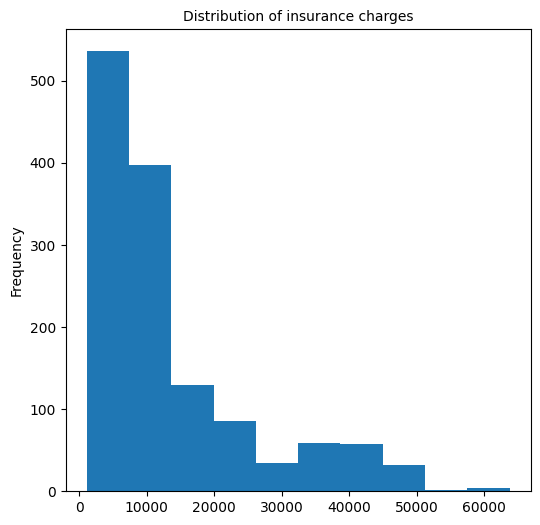

In [5]:
plt.figure(figsize=(6,6))
insurance['charges'].plot.hist()
plt.title('Distribution of insurance charges', fontsize=10)
plt.show()

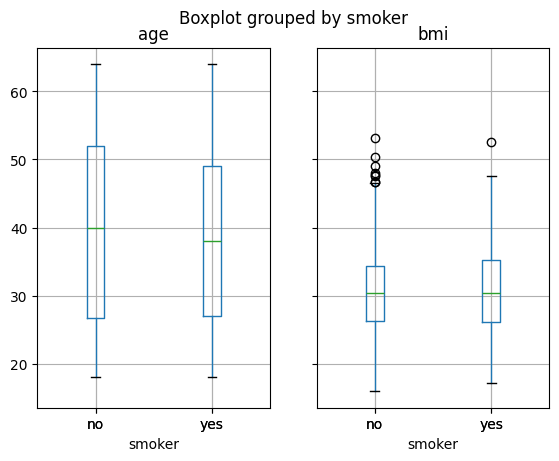

In [6]:
#sns.set_theme()
insurance.boxplot(column=['age', 'bmi'], by='smoker')
plt.show()

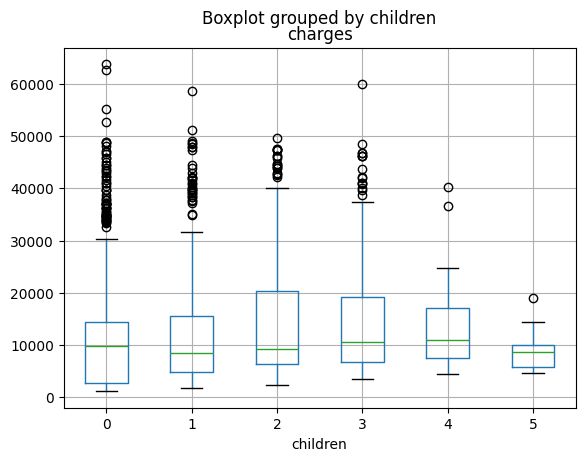

In [7]:
insurance.boxplot(column=['charges'], by='children')
plt.show()

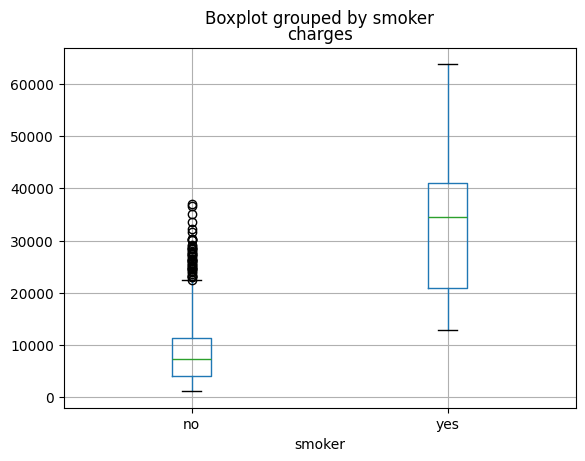

In [8]:
insurance.boxplot(column=['charges'], by='smoker')
plt.show()

There are no strong correlations observed in the numeric data between the predictors and outcome, however, bmi and age have approx 0.2 and were the highest among the four numeric data. 
In the boxplots, the mean and distribution of bmi and age are similar between smokers and non smoker. The distribution of charges per number of children increased till a max of three children but there are many outliers in the data.   
But the mean and distribution of charges based on smoker is significantly skewed to smokers and shows a strong correlation to the outcome. There may be lots of reasons to this but one factor to consider is the health risks associated with smoking.

Therefore, these three predictors will be included for modeling:
1. age: this showed a correlation of approx. 0.3 and health tend to decline with increase in age
2. bmi: this showed a correlation of approx 0.2 and bmi is a health factor
3. smoker: this has strong correlation with the outcome and is a health risk factor. 

The target column is also skewed and therefore i will do a log transformation of this target variable before modelling 

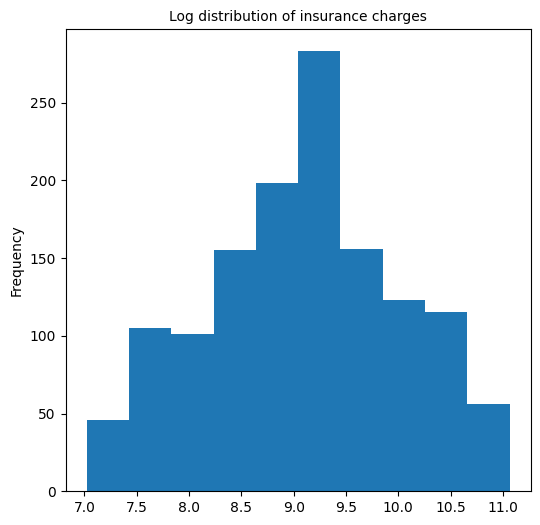

In [9]:
#Transforming the smoker column to numeric 
insurance['smoker_yes'] = np.where(insurance['smoker']=='yes', 1, 0)

#tranforming the target variable

insurance['log_charges'] = np.log(insurance['charges'])

plt.figure(figsize=(6,6))
insurance['log_charges'].plot.hist()
plt.title('Log distribution of insurance charges', fontsize=10)
plt.show()

In [10]:
# splitting the data. 80% of the data will be used in training while 20% will be used for test
cols_to_use = ['age', 'bmi', 'smoker_yes']
X = insurance[cols_to_use]
y = insurance['log_charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle = True, random_state=5)


In [11]:
lm = LinearRegression(n_jobs=-1)
lm.fit(X_train, y_train)
intercept = lm.intercept_
coef = lm.coef_

print(f'intercept: {intercept} \nSlope: {coef}')


intercept: 7.071489446917971 
Slope: [0.03493517 0.01113179 1.54573633]


In [12]:
# calculating determinant and coefficient of training data
train_pred = lm.predict(X_train)
r2 = r2_score(y_train, train_pred)
train_log_mse = mean_squared_error(y_train, train_pred)
train_log_rmse = root_mean_squared_error(y_train, train_pred)

print(f'R2 score: %s \ntraining log MSE: %s \ntraining log RMSE: %s' % (r2, train_log_mse, train_log_rmse))


R2 score: 0.7437788409593586 
training log MSE: 0.21696930339295883 
training log RMSE: 0.4657996386784331


In [13]:
print('Training MSE and RMSE on original scale')

print(f'Training MSE: %s \nTraining RMSE: %s' % (np.exp(train_log_mse), np.exp(train_log_rmse)))

Training MSE and RMSE on original scale
Training MSE: 1.242305966974364 
Training RMSE: 1.5932877341293057


All the features are significantly positively correlated with the charges which supports the negative intercept.  
The coefficients for age and bmi are similar while being a smoker has higher coefficient. Therefore being a smoker is by ffar significant on the outcome compared to other predictors.    

The R2 score of the training data shows a good account of the variance in the data. However, the MSE for the training is significant but this shall be investigated subsequently. 

In [14]:
## Investigating the assumptions of the linear model 
residuals = y_train - train_pred
residual_mean = np.mean(residuals)

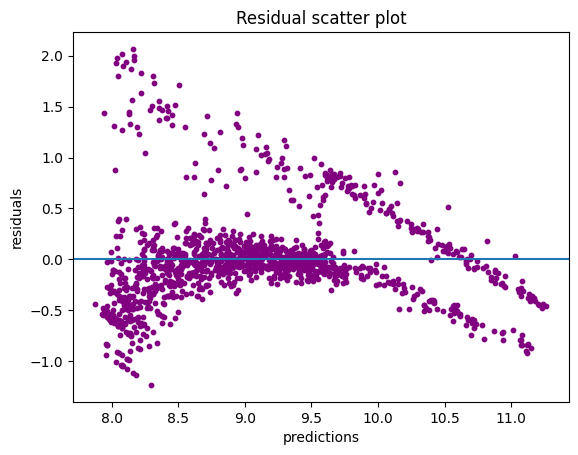

In [15]:
plt.title('Residual scatter plot')
plt.scatter(train_pred, residuals, color='purple', s=10)
plt.axhline(residual_mean)
plt.ylabel('residuals')
plt.xlabel('predictions')
plt.show()

The residual plot of the data does not center around zero but showed an increase in variance as the data increases    
If we cast a look back at the coefficient of smoker from the model, the charges will increase significantly once observed data is positive for smoking which is reflected on the residuals 

In [16]:
## testing the performance of the model on test data
test_pred = lm.predict(X_test)
test_log_MSE = mean_squared_error(test_pred, y_test)
test_log_rmse = root_mean_squared_error(test_pred, y_test)

print(f'Test log MSE {test_log_MSE} \nTest log RMSE: {test_log_rmse}')

Test log MSE 0.13927680408399618 
Test log RMSE: 0.3731980762061833


In [17]:
print('Test MSE and RMSE in original scale')
print(f'Test MSE %s \nTest RMSE %s' % (np.exp(test_log_MSE), np.exp(test_log_rmse)))

Test MSE and RMSE in original scale
Test MSE 1.1494422262747988 
Test RMSE 1.45237199167742


The test MSE is lower than the train MSE. However, in this model, the test MSE is still significantly larger than zero

##### Conclusion  

In this short model prediction with linear regression, the model is able to match the expectation that age, bmi and smoking positively correlate with health insurance cost. Of particular interest is the bmi and smoking predictors.  
BMI determines whether one is overweight which is an indication of health risk. Therefore the coefficient of BMI is slightly higher than that of age which meets the expectation for higher charge if an oberved data is overweight. Then the coefficient of smoker depicts fully the health risks associated with smoking generally and because this is a categorical variable, the impact on the outcome is significant. The charges automatically climbs once one is a smoker. Finally, the intercept balances the expectation of the data as one cannot be expected have zero age and zero bmi but can be a non-smoker. 

In conlusion, this model is a simple linear regression model which is capable of providing insight into the insurance costs for new patient data but would need more robust training and optimisation if an entire decision should be based on the model. 